# Introduction
MITRE reproduced the method from [[1]](#ref1) which applies a Monte Carlo method to reliability engineering analysis of networks.  This paper implements this method using a labeled graph representation of the network, validates results using algebraic analysis for simple graphs, explores the limits of this method, and develops two optimization of the algorithm.

# Motivation
From [[2]](#ref2), the algebraic formulation of reliability for components in series is the following product series.

$$R_s=\prod_i R_i$$

The algebraic formulation for components in parallel is the following product series.

$$R=1-\prod_{i}(1-R_i)$$

In complex systems with many parts and parallel paths, constructing these forumulations can be complex and time consuming.  A computational approach would apply to any system or network regardless of scale or complexity, and would provide a useful tool for engineering analysis.

# Definition of reliability in a network
For the purpose of this paper, we define network reliability as the probability that a path through the network between two selected vertices exists.  Vertices must be selected in advance.  This definition is useful to demonstrate and validate the algorithm, but may not represent any reliability measure for real systems.

# Implementation
The following code sets up the programming environment and imports required modules.  See the Backup & restore session state section at the end of this document to save and load variables without re-running each example.

In [ ]:
!pip install networkx matplotlib numpy pandas seaborn

In [7]:
%matplotlib inline

In [2]:
import time
import networkx as nx
import numpy.random as random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
from matplotlib import rcParams
import warnings
warnings.filterwarnings("ignore")

## Monte Carlo reliability estimation algorithm 
An experiment starts with a graph representing the components; e.g., a network.  Edges are labeled with a probability of successful operation in the range $0\le R\le 1$.

For each trial in the experiment, we create a version of the original graph with simulated failures.  For each edge in the graph we draw a random value from a uniform distribution  and remove the edge if the draw is greater than the value of $R$ on that edge.  We test the resulting graph for a path between two pre-selected nodes.  If a path exists, the trial is a success and we add 1 to an accumulator.

The reliability estimate of the original graph is the number of successful trials divided by the number of iterations.

### Binomial distribution assumption 

We assume our experimental setup follows a binomial distribution because it has the characteristics expected when a binomal distribution applies.
* Each trial is independent of other trials
* Each trial has only two outcomes, success or failure
* The same graph and R values are used in every trial so the probability of success is the same for each trial  
* The experiment contains a fixed number of trials

Assuming a binomial distribution allows us to estimate the binomial proportion confidence interval (BCPI) using the method in [[3]](#ref3).  We use a 5% error rate, and compute the 95% confidence interval following common practice.  The BCPI can be interpreted two ways.  First, if we repeat the experiment 100 times and compute the BCPI for each experiment, then 95 of these intervals will contain the true value.  Second, if we do the experiment only once, then there is a 95% chance than the interval contains the true value.

### Implementation
The following function implements the BCPI calculation.

In [7]:
# Agrest-Coull binomial proportion confidence interval estimate
# Input: Successful observations, total observations, and quantile of the standard normal
#        distribution for the desired error rate (i.e., the probit)
# Output: The lower and upper bounds of the interval
def CI(C,N,z):
    nBar = N + z**2
    cBar = (1/nBar)*(C+(z**2/2))
    l = cBar - z * ((1/nBar)*cBar*(1-cBar))**0.5
    u = cBar + z * ((1/nBar)*cBar*(1-cBar))**0.5
    return (l,u)

The following function implements the algorithm described above.

In [85]:
# Monte Carlo Reliability algorithm 1
# Input: A labeled graph, a number of trials, and a source and target node for path testing
# Output: Reliability probability point estimate and confidence interval
def R(G,I,s,d):
    C = 0
    z = 1.96 # probit(1 - (alpha/2)), where alpha is the error rate of 0.05. 
    for i in range(I):
        g = G.copy()
        to_remove = []
        for e in list(g.edges):
            if random.random() > g.edges[e]['R']:
                to_remove.append(e)
        g.remove_edges_from(to_remove)
        if nx.has_path(g,s,d):
            C += 1
    return C/I, CI(C,I,z)

# Monte Carlo algorithm validation
We validate the algorithm by exploring results with two sample graphs where the algebraic formulation can be solved, providing a true value.

## Sample 1: Single parallel path 
The first sample graph has two edges connecting two vertices.  Each edge has a different $R$ value, with $R_0=0.91$ and $R_1=0.81$.

**Note:** NetworkX does not render parallel edges.

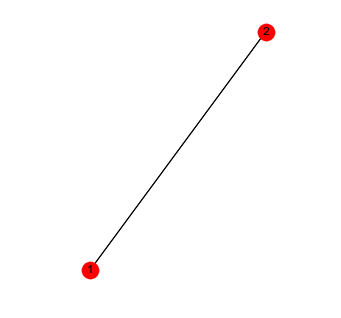

In [95]:
rcParams['figure.figsize'] = 4,4
G = nx.MultiGraph()
G.add_edges_from([(1,2),(1,2)])
nx.set_edge_attributes(G,1.0,'R')
nx.set_edge_attributes(G,{(1,2,0):{'R':0.91}, (1,2,1):{'R':0.81}})
nx.draw(G, with_labels=True)

For this simple system, $R=R_0+R_1-R_0R_1=0.9829$.

We run the Monte Carlo method, estimating reliability from node 1 to node 2.  We run the experiment multiple times with different number of trials to show how the point estimate and BCPI estimate for $R$ behave.  We time each run for comparison to later optimizations.

In [179]:
results = []
for i in range(10000,200000,10000):
    start = time.time()
    r,ci = R(G,i,1,2)
    end = time.time()
    results.append([i,r]+list(ci)+[ci[1]-ci[0],end-start])
g1_results = pd.DataFrame(results,columns=['Trials','R estimate','Lower bound','Upper bound',
                                                  'Interval','Execution time'])
g1_results['Graph'] = 1;

In [180]:
g1_results

,Trials,R estimate,Lower bound,Upper bound,Interval,Execution time,Graph
0,10000,0.981200,0.978341,0.983690,0.005349,0.885404,1
1,20000,0.983200,0.981321,0.984893,0.003572,1.574349,1
2,30000,0.984033,0.982550,0.985392,0.002842,2.671306,1
3,40000,0.983300,0.981996,0.984511,0.002515,3.174324,1
4,50000,0.982940,0.981767,0.984039,0.002272,4.107712,1
5,60000,0.982950,0.981882,0.983956,0.002074,4.776643,1
6,70000,0.983100,0.982118,0.984029,0.001911,5.476824,1
7,80000,0.983000,0.982080,0.983873,0.001793,7.033459,1
8,90000,0.983022,0.982157,0.983846,0.001689,7.446398,1
9,100000,0.982540,0.981709,0.983334,0.001624,7.966459,1


## Sample 2: Multiple parallel paths 
The second sample graph is more complex.  There are two paths from node 1 to node 8; one with path `[1,2,7,8]`, and the other with path `[1,2,3,4,5,6,7,8]`.  In addition, there are two edges connecting nodes 3 and 4, and two edges connecting nodes 5 and 6.  Edges (1,2), (6,7), and (7,8) have $R=1.0$, and all other edges have $R=0.8$.

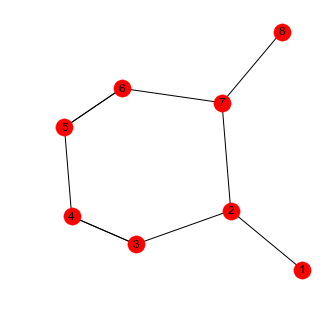

In [96]:
rcParams['figure.figsize'] = 4,4
G2 = nx.MultiGraph()
G2.add_nodes_from([1,2,3,4,5,6,7,8])
G2.add_edges_from([(1,2),(2,7),(2,3),(3,4),(3,4),(4,5),(5,6),(5,6),(6,7),(7,8)])
nx.set_edge_attributes(G2,1.0,'R')
nx.set_edge_attributes(G2,{(2,7,0):{"R":0.8}, (2,3,0):{"R":0.8}, (3,4,0):{"R":0.8}, (3,4,1):{"R":0.8}, 
                          (5,6,0):{"R":0.8}, (5,6,1):{"R":0.8}})
nx.draw(G2,with_labels=True)

The algebraic formulation for this graph is much more complex.

$$ R = R_{1,2} (R_{2,7a} + R_{2,7} - R_{2,7a} R_{2,7}) R_{7,8} $$
$$ R_{2,7a} = R_{2,3} R_{3,4} R_{4,5} R_{5,6} R_{6,7} $$
$$ R_{3,4} = R_{3,4a} + R_{3,4b} - R_{3,4a} R_{3,4b} $$
$$ R_{5,6} = R_{5,6a} + R_{5,6b} - R_{5,6a} R_{5,6b} $$

Solving these equations with the $R$ values above, the analyical result is $R=0.94756$

We run the Monte Carlo method calculating reliability from node 1 to node 8.  We collect the same data as the first example.

In [77]:
results = []
for i in range(10000,200000,10000):
    start = time.time()
    r,ci = R(G2,i,1,8)
    end = time.time()
    results.append([i,r]+list(ci)+[ci[1]-ci[0],end-start])
g2_results = pd.DataFrame(results,columns=['Trials','R estimate','Lower bound','Upper bound',
                                                  'Interval','Execution time'])
g2_results['Graph'] = 2;

In [82]:
g2_results

,Trials,R estimate,Lower bound,Upper bound,Interval,Execution time,Graph
0,10000,0.947000,0.942431,0.951225,0.008794,3.073508,2
1,20000,0.948850,0.945708,0.951819,0.006111,6.425468,2
2,30000,0.945667,0.943043,0.948176,0.005132,9.639256,2
3,40000,0.947675,0.945449,0.949815,0.004366,13.034265,2
4,50000,0.947440,0.945449,0.949362,0.003913,16.123429,2
5,60000,0.948033,0.946228,0.949781,0.003553,19.032092,2
6,70000,0.946000,0.944301,0.947650,0.003349,21.964479,2
7,80000,0.946837,0.945261,0.948371,0.003110,25.489109,2
8,90000,0.947456,0.945979,0.948894,0.002916,28.639958,2
9,100000,0.947750,0.946353,0.949112,0.002759,31.502276,2


These results show that the algorithm produces values near the true value.  These results will be discussed more below.

## Error rate verification
A confidence interval will sometimes produce erroneous results.  An erroroneous result is when the true value is outside the interval.  Such instances were found during this investigation.  The the error rate should be 5%.  We execute the algorithm above many times and measure the error rate by counting the number of experimental runs where the true value is outside the BCPI.

In [165]:
results = []
for i in range(500):
    start = time.time()
    r,ci = R(G,10000,1,2)
    end = time.time()
    results.append([i,10000,r]+list(ci)+[ci[1]-ci[0],end-start])
g1_error_results = pd.DataFrame(results,columns=['Run','Trials','R estimate','Lower bound','Upper bound',
                                                  'Interval','Execution time'])
g1_error_results['Graph'] = 1;

In [171]:
total_errors = ([i for (i,r) in g1_error_results.iterrows() if 
 (r['Upper bound']<0.9829) or (r['Lower bound']>0.9829)])
print('Total errors: {}\nError rate: {}'.format(len(total_errors), len(total_errors)/500))

Total errors: 24
Error rate: 0.048


The error rate of 4.8% is close to the 5% error rate specified.

## Results verification
The top two figures below plot the point estimate and interval bounds against the true value for the experiments above.  The third figure plots the size of the BCPI against the number of trials.  The final figure plots the distribution of R estimates for 500 runs of 10,000 trials each against the true value.

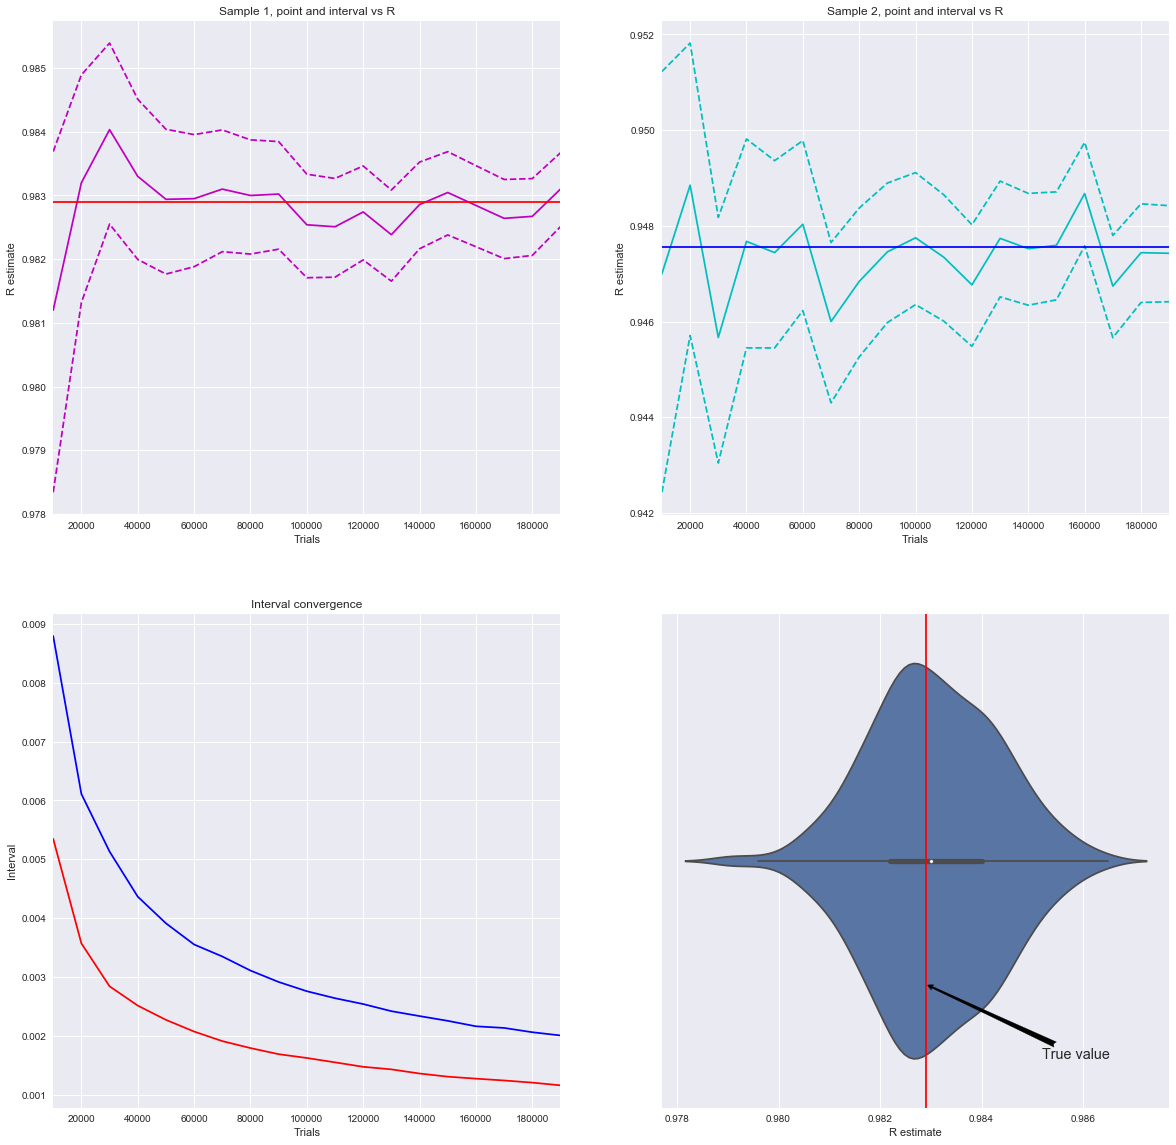

In [312]:
rcParams['figure.figsize'] = 20,20
plt.subplot(221)
ax = sns.tsplot(g1_results,time='Trials',unit='Graph',value='Lower bound',
                color='m',ls='dashed')
ax = sns.tsplot(g1_results,time='Trials',unit='Graph',value='Upper bound',
                color='m',ls='dashed')
ax = sns.tsplot(g1_results,time='Trials',unit='Graph',value='R estimate',color='m')
ax = plt.plot([10000,190000],[0.9829,0.9829],color='r')
plt.title('Sample 1, point and interval vs R')
plt.subplot(222)
ax = sns.tsplot(g2_results,time='Trials',unit='Graph',value='Lower bound',
                color='c',ls='dashed')
ax = sns.tsplot(g2_results,time='Trials',unit='Graph',value='Upper bound',
                color='c',ls='dashed')
ax = sns.tsplot(g2_results,time='Trials',unit='Graph',value='R estimate',color='c')
plt.title('Sample 2, point and interval vs R')
ax = plt.plot([10000,190000],[0.94756,0.94756],color='b')
plt.subplot(223)
plt.title('Interval convergence')
ax = sns.tsplot(g1_results,time='Trials',unit='Graph',value='Interval',color='r')
ax = sns.tsplot(g2_results,time='Trials',unit='Graph',value='Interval',color='b')
plt.subplot(224)
ax = sns.violinplot(x=g1_error_results["R estimate"])
plt.plot([0.9829,0.9829],[-100,100],color='r')
ax.annotate('True value',xy=(0.9829,0.25),xycoords='data',
            xytext=(0.75,0.1),textcoords='axes fraction',
            arrowprops=dict(arrowstyle="fancy",facecolor='black',
                            connectionstyle="arc3"),fontsize='large');

The Monte Carlo method produces accurate reliability probability estimates when a large enough number of trials are executed.  The data shows that both the point estimate converges on the true value, and the interval converges smoothly toward zero.  Both results are expected.

## Validity conclusions and considerations
We conclude that the algorithm is valid.  

Care must be taken when using this algorithm to ensure that erroneous results are not used, or the impact of errors is limited.  Because the point estimate and interval are converging and the error is normally distributed, the probability of a significant error in the point estimate also decreases as the number of trials increase.

The potential and impact of these errors therefore decreases with the size of the experiment, and will not affect results as long as a sufficient number of trials are run.  This characteristic of the BCPI suggests a modification of the algorithm, discussed below.

# Optimizations
Inspecting the runtimes for this algorithm shows that the Monte Carlo method can take a significant time to run.  Multiple experiments may be required to ensure that the error probabilty and impact is limited sufficiently for a given purpose.  

In this section, we optimize the algorithm in two ways; first, by using the observed convergence to stop the experiment, and second, by implementing a multi-process version to take advantage of multi-core computer architectures.

## Optimization 1: Convergence modification
We modify the basic algorithm to run trials until the BCPI is smaller than a desired value.  The BCPI converges on zero as the number of trials approaches infinity, and the BCPI only requires the number of trials and number of successes, and can therefore be calculated after each trial.  This allows us to run a single experiment that stops when it reaches a desired level of confidence, saving us the time require to ascertain a necessary number of trials in advance.

### Impact on the binomial assumption
Normally the binomial distribution assumption requires a fixed number of trials.  Incrementally calculating the BCPI is the same as repeating the experiment from the beginning each time because all trials are independent.  Results from this method will have the same distribution as if we pre-selected the number of trials in advance.  

### Implementation

In [113]:
# Monte Carlo Reliability algorithm 2
# Input: A labeled graph, a confidence interval stopping point, and
#       a source and target node
# Output: Reliability probability, confidence interval
def R2(G,I,s,d):
    C = 0
    N = 0
    z = 1.96 # probit(1 - (alpha/2)), where alpha is the error rate of 0.05. 
    l,u = CI(C,N,z)
    while (u-l)>I:
        g = G.copy()
        to_remove = []
        for e in list(g.edges):
            if random.random() > g.edges[e]['R']:
                to_remove.append(e)
        g.remove_edges_from(to_remove)
        if nx.has_path(g,s,d):
            C += 1
        N += 1
        l,u = CI(C,N,z)
    return C/N, CI(C,N,z), N

### Validation of algorithm 2
We run this algorithm 500 times on the first sample, stopping when $BCPI \le 0.003$.  Refering to the result of algorithm 1, we expect this algorithm to have similar results to the following experimental run of algorithm 1.

In [188]:
g1_results.ix[2]

Trials            30000.000000
R estimate            0.984033
Lower bound           0.982550
Upper bound           0.985392
Interval              0.002842
Execution time        2.671306
Graph                 1.000000
Name: 2, dtype: float64

In [176]:
results = []
for i in range(500):
    start = time.time()
    r,ci,n = R2(G,0.003,1,2)
    end = time.time()
    results.append([i,n,r]+list(ci)+[ci[1]-ci[0],end-start])
g1_r2_results = pd.DataFrame(results,columns=['Run','Trials','R estimate',
                                              'Lower bound','Upper bound',
                                              'Interval','Execution time'])
g1_r2_results['Graph'] = 1;

We validate that the error rate remains within expected bounds.

In [317]:
total_errors = ([i for (i,r) in g1_r2_results.iterrows() if 
 (r['Upper bound']<0.9829) or (r['Lower bound']>0.9829)])
print('Total errors: {}\nError rate: {}'.format(len(total_errors), len(total_errors)/500))

Total errors: 38
Error rate: 0.076


The error rate in this case is 7.6%, which is greater than the 5% target.  This method is expected to have variation in the error rate because of the random process, but it should converge on the selected rate as the experiment is repeated.  Previous runs with fewer experiments yielded an even higher error rate, so we conclude the error rate converges on the 5% target with more experiment repititions.

Finally, we verify validity of the R estimate.

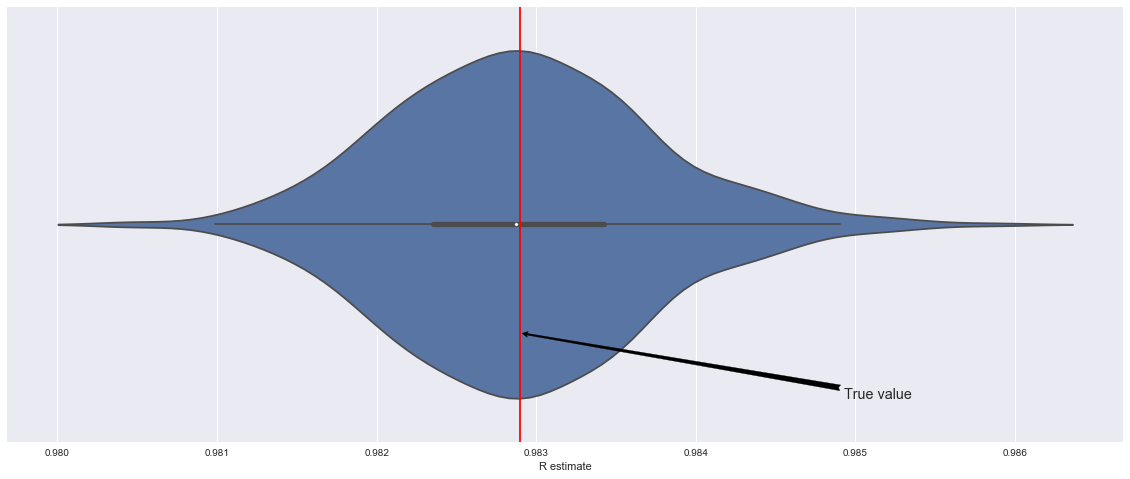

In [327]:
rcParams['figure.figsize'] = 20,8
ax = sns.violinplot(x=g1_r2_results["R estimate"])
plt.plot([0.9829,0.9829],[-1,1],color='r')
ax.annotate('True value',xy=(0.9829,0.25),xycoords='data',
            xytext=(0.75,0.1),textcoords='axes fraction',
            arrowprops=dict(arrowstyle="fancy",facecolor='black',
                            connectionstyle="arc3"), fontsize='large');

We conclude that varying the number of trials until the BCPI is smaller than a set value does not impact the validity of the results.  The error probability of this algorithm 2 is the same as algorithm 1.

## Optimization 2:  Parallel execution
Monte Carlo methods are highly parallelizable because trials are independent.  We speed up reliability estimation by batching the experiment and running multiple processes.  We combine this with the convergence modification of algoritm 2 by create worker processes that run a fixed number of iterations, collecting their results, testing the BCPI, and spawning additional workers if the interval has not converged sufficiently.

### Parallel algorithm and implementation
`R3worker()` runs a fixed number of trials, and the `R3()` function spawns 2 processes running the worker function and collects the results.  After each spawned process returns results, the BCPI is tested against the desired value, and new workers are spawned until the desired interval is reached.  

This is slightly less efficient than best case; at most, $2\times i-1$ iterations will be wasted.  However, this design is simple and will translate easily to multi-host parallel libraries.

We use the Python `multiprocessing.Pool` class to handle process management and output collection.  We use the `multiprocessing` rather than `threading` module because Python threads run in a single interpreter process and are constrained to a single core.  However, the `multiprocessing` module incurrs process management overhead, so speedup is somewhat less than $2\times$.

In [265]:
from multiprocessing import Pool

# Monte Carlo Reliability algorithm 3 worker function
# Input: A labeled graph, iterations to run, and a source and target node
# Output: Number of successful observations and total number of observations
def R3worker(G,I,s,d):
    random.seed() # Gotcha:  Pool processes get the same PRNG state. Must reseed.
    C = 0
    for i in range(I):
        g = G.copy()
        to_remove = []
        for e in list(g.edges):
            if random.random() > g.edges[e]['R']:
                to_remove.append(e)
        g.remove_edges_from(to_remove)
        if nx.has_path(g,s,d):
            C += 1
    return (C,I)

# Monte Carlo Reliability algorithm 3 - parallel
# Input: A labeled graph, the confidence interval target, and a source and target node
# Output: Reliability probability, confidence interval
def R3(G,I,s,d):
    C = 0
    N = 1
    z = 1.96
    l,u = CI(C,N,z)
    with Pool(processes=2) as p: 
        while (u-l)>I:
            results = p.starmap(R3worker, [(G,10000,s,d),(G,10000,s,d)])
            C += sum(c for c,_ in results)
            N += sum(n for _,n in results)
            l,u = CI(C,N,z)
    return C/N, CI(C,N,z), N    

### Limitations and considerations
The number of parallel processes should be limited to one per CPU core.  All runs in this section were executed on an Intel i5-5250U clocked at 2.7 GHz.  This processor has 2 physical cores.  Some systems may report 4 virtual CPUs when hyperthreading is enabled because two threads can run per core, but this offers no additional speedup as a core can only execute one thread at a time.

### Validation of algorithm 3
We run this algorithm 500 times on the first sample, stopping when $BCPI \le 0.003$.

In [266]:
results = []
for i in range(500):
    start = time.time()
    r,ci,n = R3(G,0.003,1,2)
    end = time.time()
    results.append([i,n,r]+list(ci)+[ci[1]-ci[0],end-start])
g1_r3_results = pd.DataFrame(results,columns=['Run','Trials','R estimate',
                                              'Lower bound','Upper bound',
                                              'Interval','Execution time'])
g1_r3_results['Graph'] = 1;

In [267]:
r2 = g1_r2_results['Execution time'].sum()
r3 = g1_r3_results['Execution time'].sum()

print("R2 total execution time: {:.2f} seconds".format(r2))
print("R3 total execution time: {:.2f} seconds".format(r3))
print("Speedup: {:.2f}".format(r2/r3))

R2 total execution time: 1271.66 seconds
R3 total execution time: 1058.18 seconds
Speedup: 1.20


In this experiment the parallel algorithm executes an exess number of trials because the BCPI reaches our threshold at around 30,000 trials, and algorithm 3 runs in 20,000 trial increments.  Speedup will approach 2 as the number of trials increases.

The error rate should be roughly the same as algorithm 2 and near the target rate of 5%.

In [268]:
total_errors = ([i for (i,r) in g1_r3_results.iterrows() if 
 (r['Upper bound']<0.9829) or (r['Lower bound']>0.9829)])
print('Total errors: {}\nError rate: {}'.format(len(total_errors), len(total_errors)/500))

Total errors: 24
Error rate: 0.048


Similarly, the median of the 500 runs above should be close to the true value.

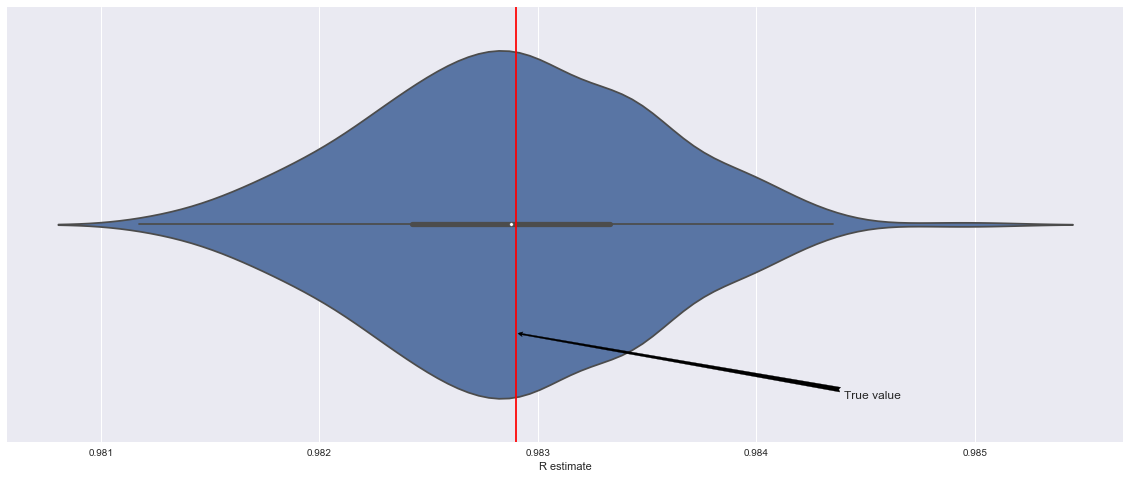

In [8]:
rcParams['figure.figsize'] = 20,8
ax = sns.violinplot(x=g1_r3_results["R estimate"])
plt.plot([0.9829,0.9829],[-1,1],color='r')
ax.annotate('True value',xy=(0.9829,0.25),xycoords='data',
            xytext=(0.75,0.1),textcoords='axes fraction',
            arrowprops=dict(arrowstyle="fancy",facecolor='black',
                            connectionstyle="arc3"), fontsize='large');

We conclude that the parallel algorithm does not impact the validity of the results.  The error probability of this algorithm 3 is the same as algorithms 1 and 2.

# Conclusions
MITRE finds the method from [[1]](#ref1) to be valid and easy to implement and extend.  We demonstrate that the algorithm performs in reasonable time.  We implemented two simple optimization that produced performance gains in line with expectations.

MITRE's investigation explored the limits of this method.  Particular attention to interpreting the R value point estimate and confidence interval is required to apply results in a meaningful way.  Specifically, experiments using this method should be repeated a significant number of times to ensure that the point estimate is not an error result, and that the point estimate is converging.  The confidence interval threshold should be stricter than otherwise required when using only single experimental runs to limit the risk of a significant deviation.

# References

<a name="ref1"></a>[1] J.L. Marden, Jr.  "Using OPNET to calculate network availability & reliability."  McLean, VA: Booz Allen Hamilton, 2013. Available: https://splash.riverbed.com/docs/DOC-2294.

<a name="ref2"></a>[2] R. Billinton and R. N. Allan. _Reliability Evaluation of Engineering Systems, Concepts and Techniques, 2nd Ed._ New York: Plenum Press, 1992.

<a name="ref3"></a>[3] A. Agresti and B. A. Coull. "Approximate is better than 'exact' for interval estimation of binomial proportions". _The American Statistician_, 52, pp.119–126, 1998.

# Backup & restore session state

In [348]:
# Save critical variables for future sessions
import pickle
with open('MCRE-variables-save.p','wb') as f:
    pickle.dump([G,
                 G2,
                 g1_results,
                 g2_results,
                 g1_error_results,
                 g1_r2_results,
                 g1_r3_results],
                f)

In [5]:
import pickle
with open('MCRE-variables-save.p','rb') as f:
     G,G2,g1_results,g2_results,g1_error_results,g1_r2_results,g1_r3_results = pickle.load(f)